In [1]:
from scipy.special import logsumexp
from scipy.stats import norm
import sys 
sys.argv[1]=1
from main import *
import os
import pickle
from plot_config import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# power will change when readed to list 10** [200, 1000, 5000, 10000, 20000]
mcmc_setup

{'cluster_maximum': 7, 'power': 10, 'iterations': 4000, 'n_chains': 4}

In [3]:
model_setup

{'power': 10, 'gem_alpha': 0.5}

In [4]:
data_config

{'alpha': 500,
 'n_sample': 5000,
 'w0': [0.7, 0.3],
 'mu0': [-2, 2],
 'sigma0': [0.7, 0.8]}

In [5]:
power_list = 10**np.round(np.linspace(1,4,31),1)

# 1. Load Fitted Model

*** Need to run Rob_bayes_Experiment.py first to generate .pickle files

In [6]:
def generate_list(path):
    """
        Function to generate a list of fitted stan name
    
    """
    files = os.listdir(path)

    data_list = []
    fitted_exact = []
    fitted_approx = []
    fitted_standard = []

    for sub_files in files:
        if sub_files.startswith('fit_correct'):
            fitted_exact.append(sub_files)
        elif sub_files.startswith('fit_approx'):
            fitted_approx.append(sub_files)
        elif sub_files.startswith('fit_standard'):
            fitted_standard.append(sub_files)
        elif sub_files.startswith('data'):
            data_list.append(sub_files)
    return fitted_standard, fitted_exact, fitted_approx, data_list

    

def load_fitted_object(pickle_names, path):
    """
        Function to load pickle object,
        params: names, List of pickle names
        params: directory to which the those pickles are stored

    """
    List = []
    for sub_name in pickle_names:
        print(path + sub_name)
        with open(path + sub_name, "rb") as f:
            fitted_object = pickle.load(f)

        List.append(fitted_object)
    return List

def estimate_pi_k(fitted_object, threshold = 0.02):
    """
        Function to estimate the probability of total clusters equal to k,
        params: fitted_object, fitted pystan object, 
        return, prob_list, a list of probabilities indicating cluster equal to k.

    """
    total_samples = mcmc_setup['iterations'] * mcmc_setup['n_chains']/2
    prob_list = []
    for i in range(1, mcmc_setup['cluster_maximum']+1):
        prob_list.append(
            np.sum(np.sum(fitted_object['fit']['theta'] > threshold, axis=1) == i) / total_samples)

    return prob_list    


def p_xj(i, fitted_object):
    """
        Sub function to calculate the pxj using weight * prob (i| mu, sigma) for the i th sample
    """
    
    normal_density = lambda  x, mu, sigma2: 0.5/np.pi *np.exp( -(x-mu)**2/ (2*sigma2) )


    n = int(mcmc_setup['iterations'] * mcmc_setup['n_chains']/2)

    f_x = normal_density(i, fitted_object['fit']['mu'].reshape([n , mcmc_setup['cluster_maximum']]), fitted_object['fit']['sigma2'])

    weights = fitted_object['fit']['theta']
    
    return np.sum(f_x * weights, axis=1)




def calc_loglikeli_changed2(fitted_object):
    """
        Function to calculate the log likelihood using the posterior samples
    """
        
    n = int(mcmc_setup['iterations'] * mcmc_setup['n_chains']/2)
    data = fitted_object['fit'].data['y']
    log_theta = fitted_object['fit']['theta']
    
    mu_matrix = fitted_object['fit']['mu']
    mu_matrix = mu_matrix.reshape([1, n , mcmc_setup['cluster_maximum']])

    sigma2_matrix = fitted_object['fit']['sigma2']
    sigma2_matrix = sigma2_matrix.reshape([1, n, mcmc_setup['cluster_maximum']])

    data = np.reshape(data, [data_config['n_sample'],1, 1])

    lnorm_pdf = np.log(norm.pdf(data, mu_matrix, sigma2_matrix))

    lnorm_pdf_total = np.sum(lnorm_pdf, axis=0)
    
    return np.mean(logsumexp( log_theta + lnorm_pdf_total, axis=1))



def load_estimate_pi_k(path, model, threshold = 0.02 ,neighbor= 2):
    """
        Function to generaete a plot indicating how many clusters are there
        params: path, directory to which the those pickles are stored

    """
    regex_alpha = r''+str(model)+'(\d.*?).pickle'
    pat_alpha = re.compile(regex_alpha, re.S)
    fitted_standard, fitted_exact, fitted_approx, data_list = generate_list(
    path)
    power_list = np.array(pat_alpha.findall(str(fitted_exact)[1:-1]), dtype=float)
    
    if model == 'fit_correct':
        model_list= [fitted_exact]
    elif model == 'fit_approx':
        model_list= [fitted_approx]
    
    like_li_list = []
    pi_k_list = []
    for model_names in model_list:
        #plt.figure(figsize=(10, 6))
        fitted_model = load_fitted_object(model_names, path)
        
        for model_object in fitted_model:
            like_li_list.append(calc_loglikeli_changed2(model_object))
            
            pi_k_list.append(np.dot(range(1, mcmc_setup['cluster_maximum']+1),estimate_pi_k(model_object, threshold = threshold)))
            
            
    
    plt.scatter(pi_k_list,like_li_list)
    plt.title('Calibration of Alpha for ' + str(model)+ '')
    plt.ylabel('E[LogLikeli |data]')
    plt.xlabel('E[K_{2%}|data]')
    try:
        close_to_true = np.argpartition(np.abs(np.array(pi_k_list) - len(data_config['w0'])), neighbor)[:neighbor]
        alpha_index = np.argmax(np.array(like_li_list)[close_to_true])
        best_alpha = power_list[close_to_true][alpha_index]
        likeli_correct = np.array(like_li_list)[close_to_true]
        plt.plot(np.array(pi_k_list)[close_to_true][alpha_index], likeli_correct[alpha_index], 'rx')
        plt.text(np.array(pi_k_list)[close_to_true][alpha_index], likeli_correct[alpha_index], 'alpha='+str(np.round(best_alpha,2)))
    except:
        print('No alpha could give the correct cluster number')


    return like_li_list, pi_k_list, power_list



def plot_estimate_pi_k(model, path, alpha= None):
    
    if model =='fit_correct':
        files = np.load( path +'fit_correct.npz')        
    elif model =='fit_approx':
        files = np.load(path + 'fit_approx.npz')
    
    like_li_list = files['arr_0']    
    pi_k_list = files['arr_1']    
    power_list = files['arr_2']
    
    left_point_index = np.argmin(pi_k_list)

    left_cluster = pi_k_list[left_point_index]
    left_likeli = like_li_list[left_point_index]

    flag1 = (like_li_list <= left_likeli)
    flag2 = (like_li_list >= left_likeli)
    lower_plot = np.array([ like_li_list, pi_k_list])[:,flag1]
    upper_plot = np.array([ like_li_list, pi_k_list])[:,flag2]
    plt.figure(figsize=(10, 6))
    plt.plot(lower_plot[1][lower_plot.argsort()[1]], lower_plot[0][lower_plot.argsort()[1]], 'b')
    plt.plot(upper_plot[1][upper_plot.argsort()[1]], upper_plot[0][upper_plot.argsort()[1]], 'b')

    plt.plot(left_cluster, left_likeli, 'rx')
    
    plt.text(left_cluster, left_likeli, 'alpha='+str(np.round(power_list[left_point_index],2)))

    plt.title('Calibration of Alpha for ' + str(model)+ '')
    plt.ylabel('E[LogLikeli |data]')
    plt.xlabel('E[K_{2%}|data]')
    if alpha is not None:
        
        plt.plot(pi_k_list [[power_list == alpha]], like_li_list [power_list == alpha], 'gx')
        plt.text(pi_k_list [[power_list == alpha]], like_li_list [power_list == alpha], 'alpha=' + str(np.round(power_list[power_list==alpha],2)[0]))

    
        
        

In [ ]:
path = "Alpha_result/"
data_names = generate_list(path)[-1]
data_lists = load_fitted_object(data_names, path)

n_sample_list = pat.findall(str(data_names))
n_sample_cycler = cycle(n_sample_list)
    
for data in data_lists:
    sns.distplot(data['pertubation'], label='Pertubated_Data')
    sns.distplot(data['true'], label='True_Data')
    plt.title('n_sample = ' + next(n_sample_cycler))
    plt.legend()
    plt.show()

# 2.  Estimating the Probabilities of Total Clusters

In [ ]:
#a,b,c = load_estimate_pi_k(path, 'fit_approx', threshold = 0.02 ,neighbor= 2)
#np.savez('Alpha_result/fit_correct.npz',a ,b, c)

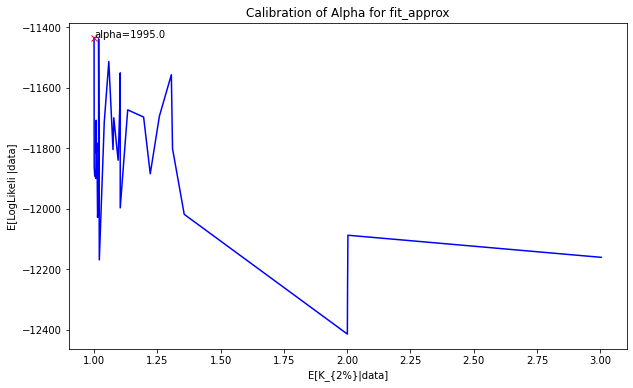

In [8]:
plot_estimate_pi_k('fit_approx', path)

# 3. Divergence Analysis

****** First Input the name of fitted pickle that you want to check for divergence

In [7]:
path = 'Alpha_result/'

In [9]:
fitted_names = ['fit_approx1995.pickle']
fitted_object = load_fitted_object(fitted_names, path)[0]
data = load_fitted_object(['data' + pat.findall(str(fitted_names))[0] + '.pickle'], path)[0]

Alpha_result/fit_approx1995.pickle
Alpha_result/data1995.pickle


## 3.1 $R_{hat}$ table, trace plot, autocorrelation plot and  pair plot

Inference for Stan model: anon_model_98c65c1e58868b08bab6d09e08519771.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

            mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
v[1]         1.0  1.3e-4 1.5e-3     1.0     1.0     1.0    1.0    1.0    131   1.02
v[2]        0.59    0.14   0.31    0.08    0.28     0.6   0.92    1.0      5   1.26
v[3]        0.76     0.1   0.29    0.07    0.58    0.89    1.0    1.0      8   1.16
v[4]        0.75    0.11   0.29    0.06    0.56    0.89    1.0    1.0      8   1.16
v[5]        0.71    0.05   0.27    0.06    0.56    0.84   0.89    1.0     28   1.05
v[6]        0.75    0.11    0.3    0.07    0.55    0.89    1.0    1.0      7   1.17
v[7]        0.58    0.12    0.3    0.07    0.31    0.55   0.89    1.0      7   1.18
mu[1,1]    -0.91    0.02   0.05   -1.01   -0.94    -0.9  -0.87  -0.83      9   1.14
mu[2,1]    -1.21    1.32    4.1   -8.19   -4.25   -1.83

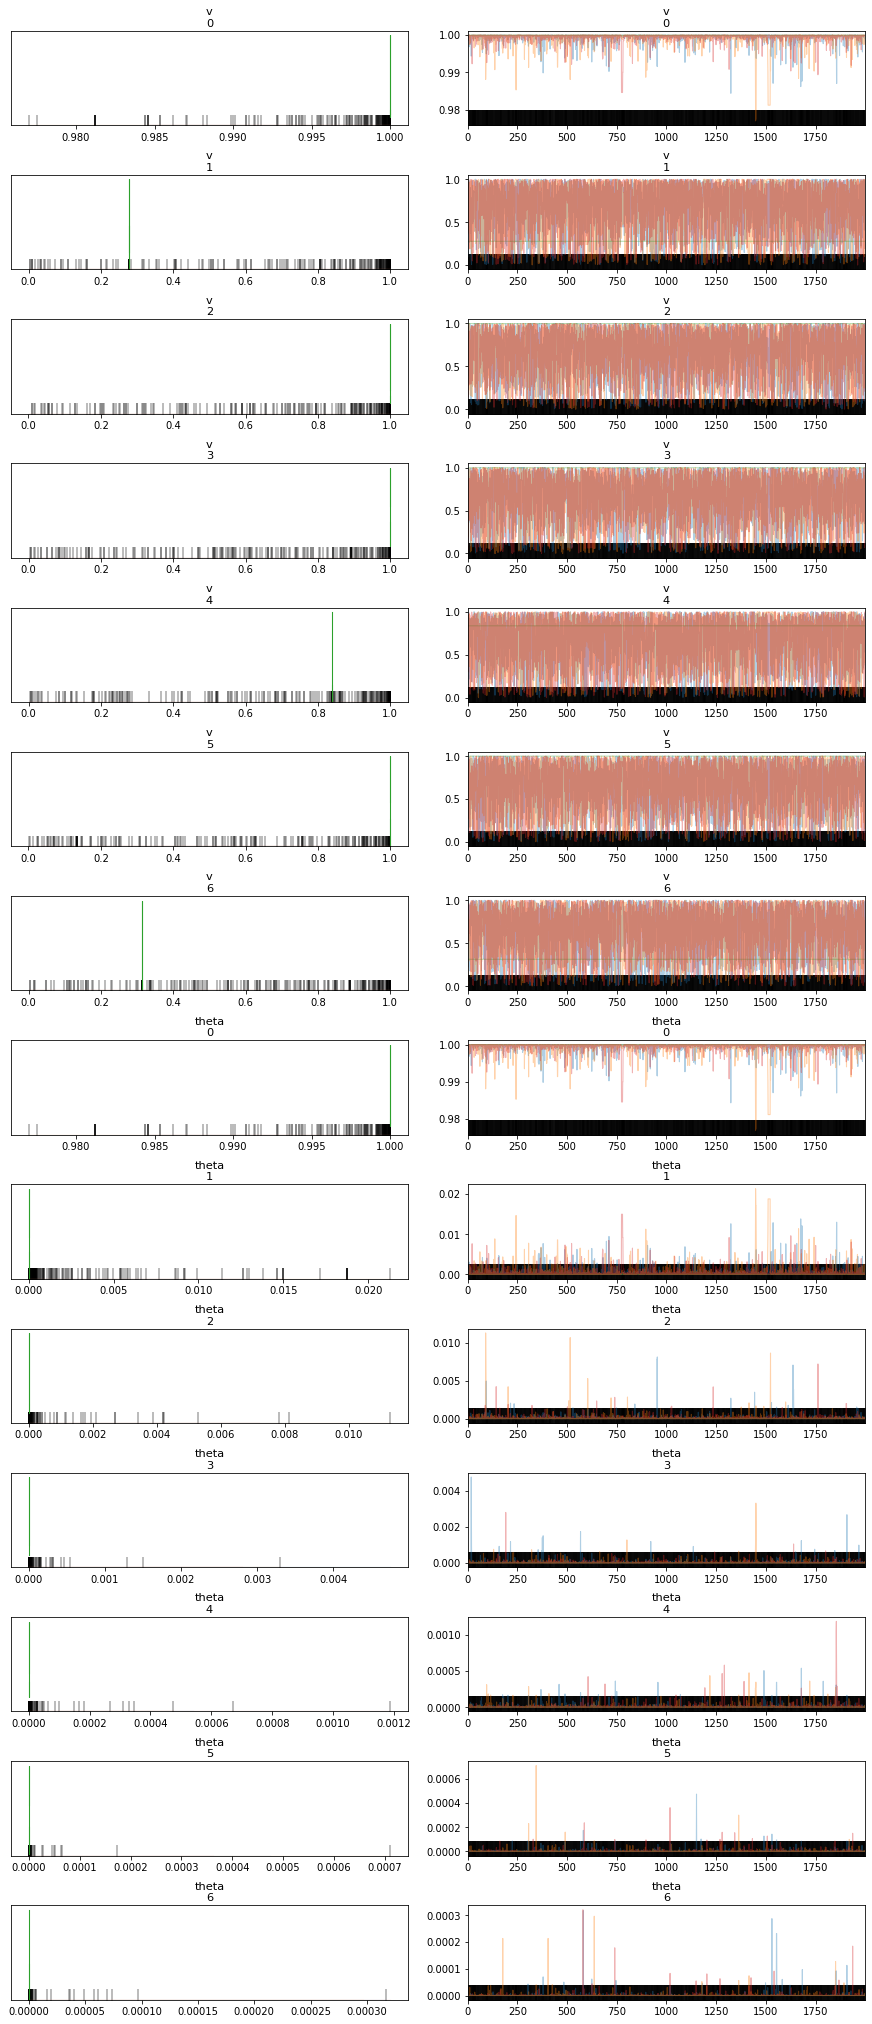

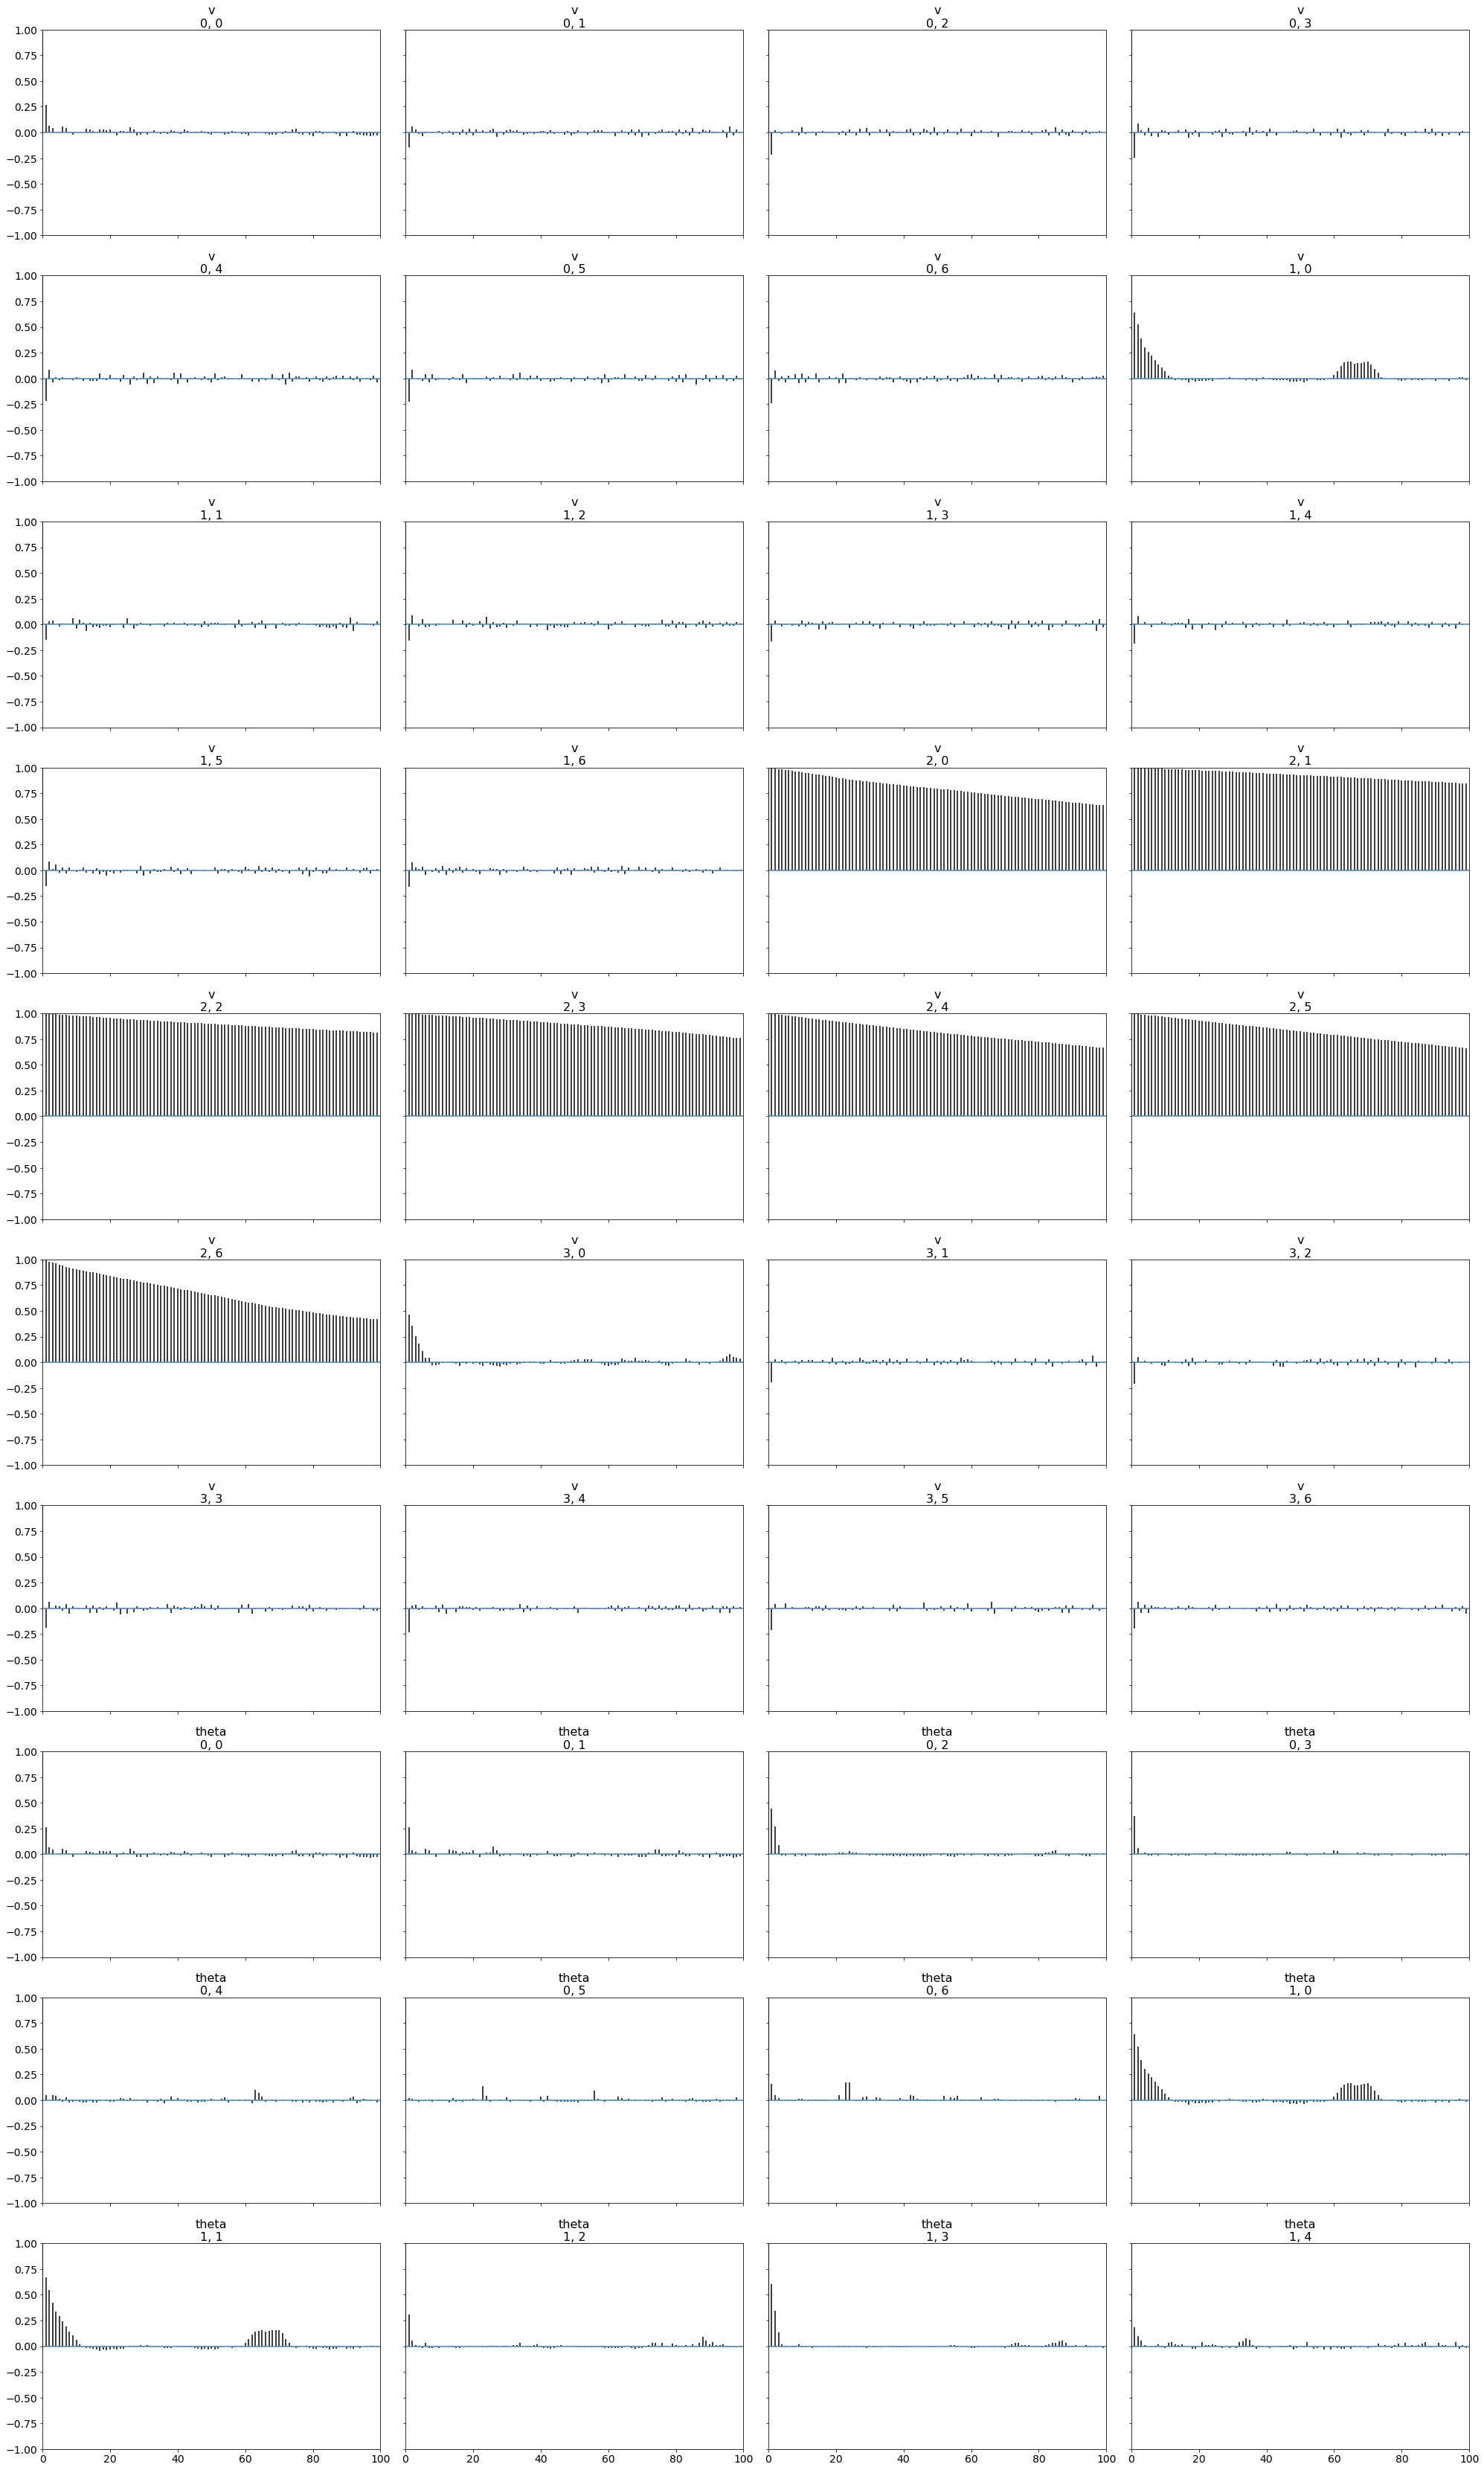

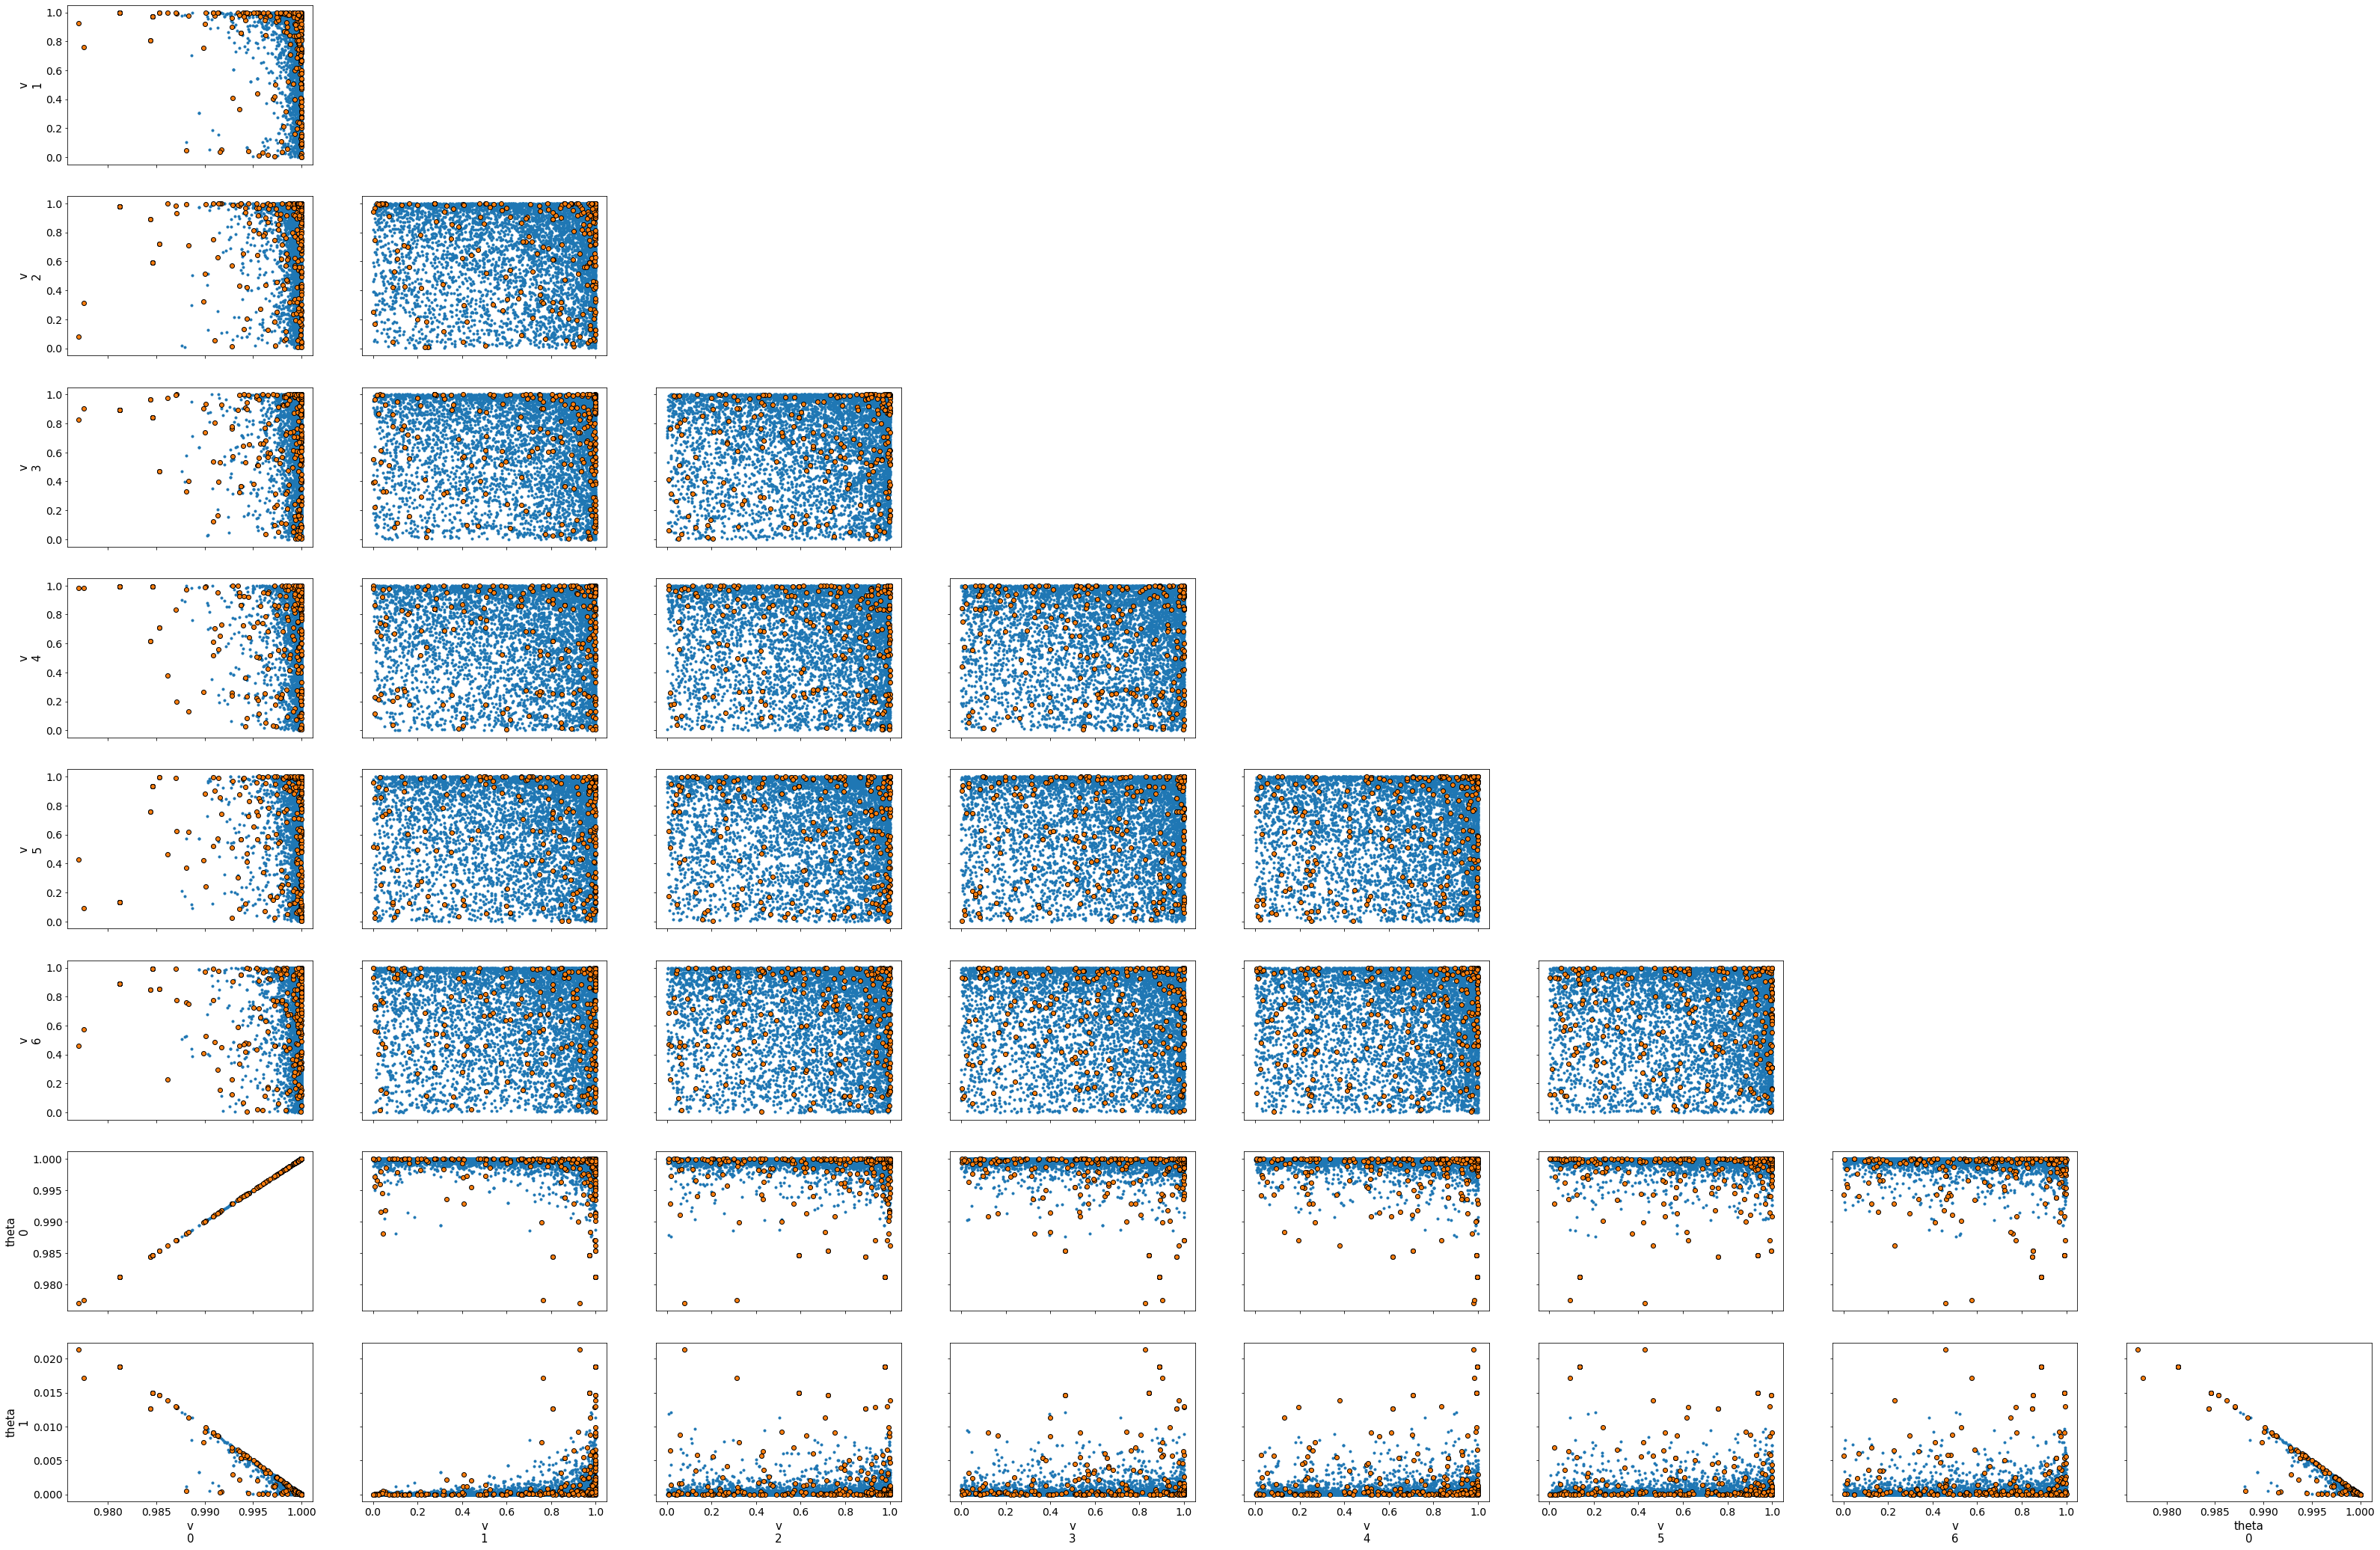

In [10]:
az_v_theta_plot(fitted_object['fit'])

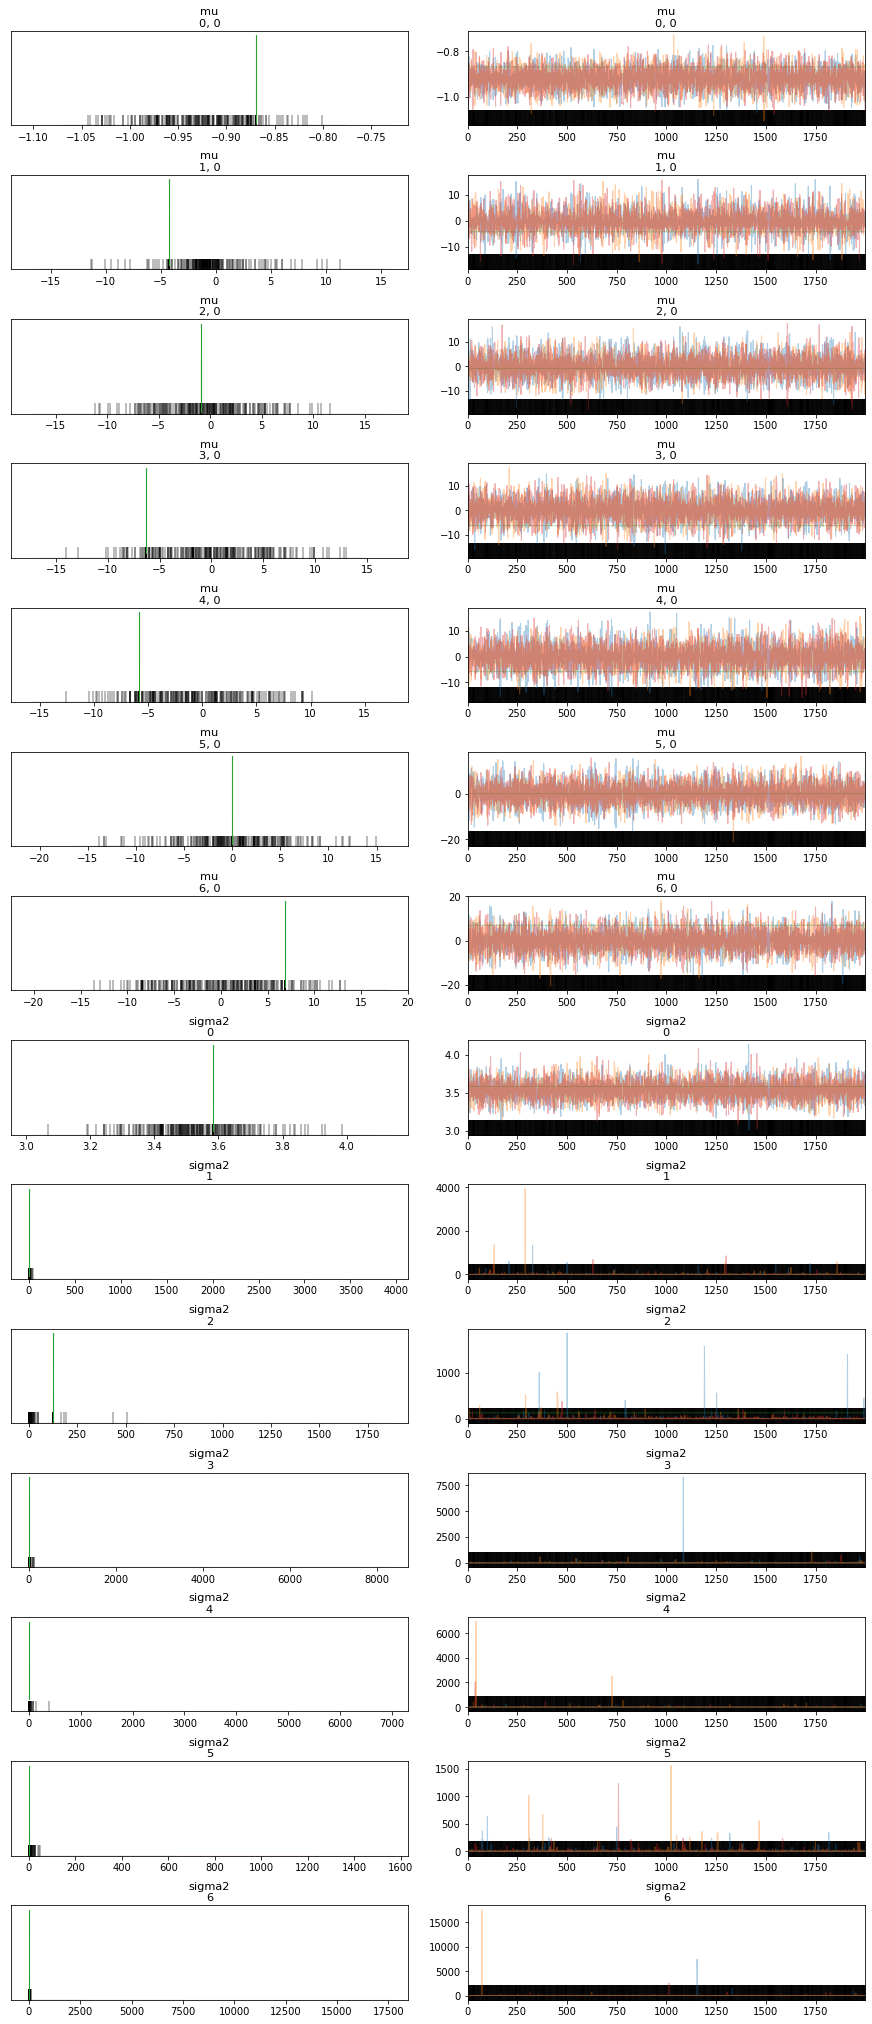

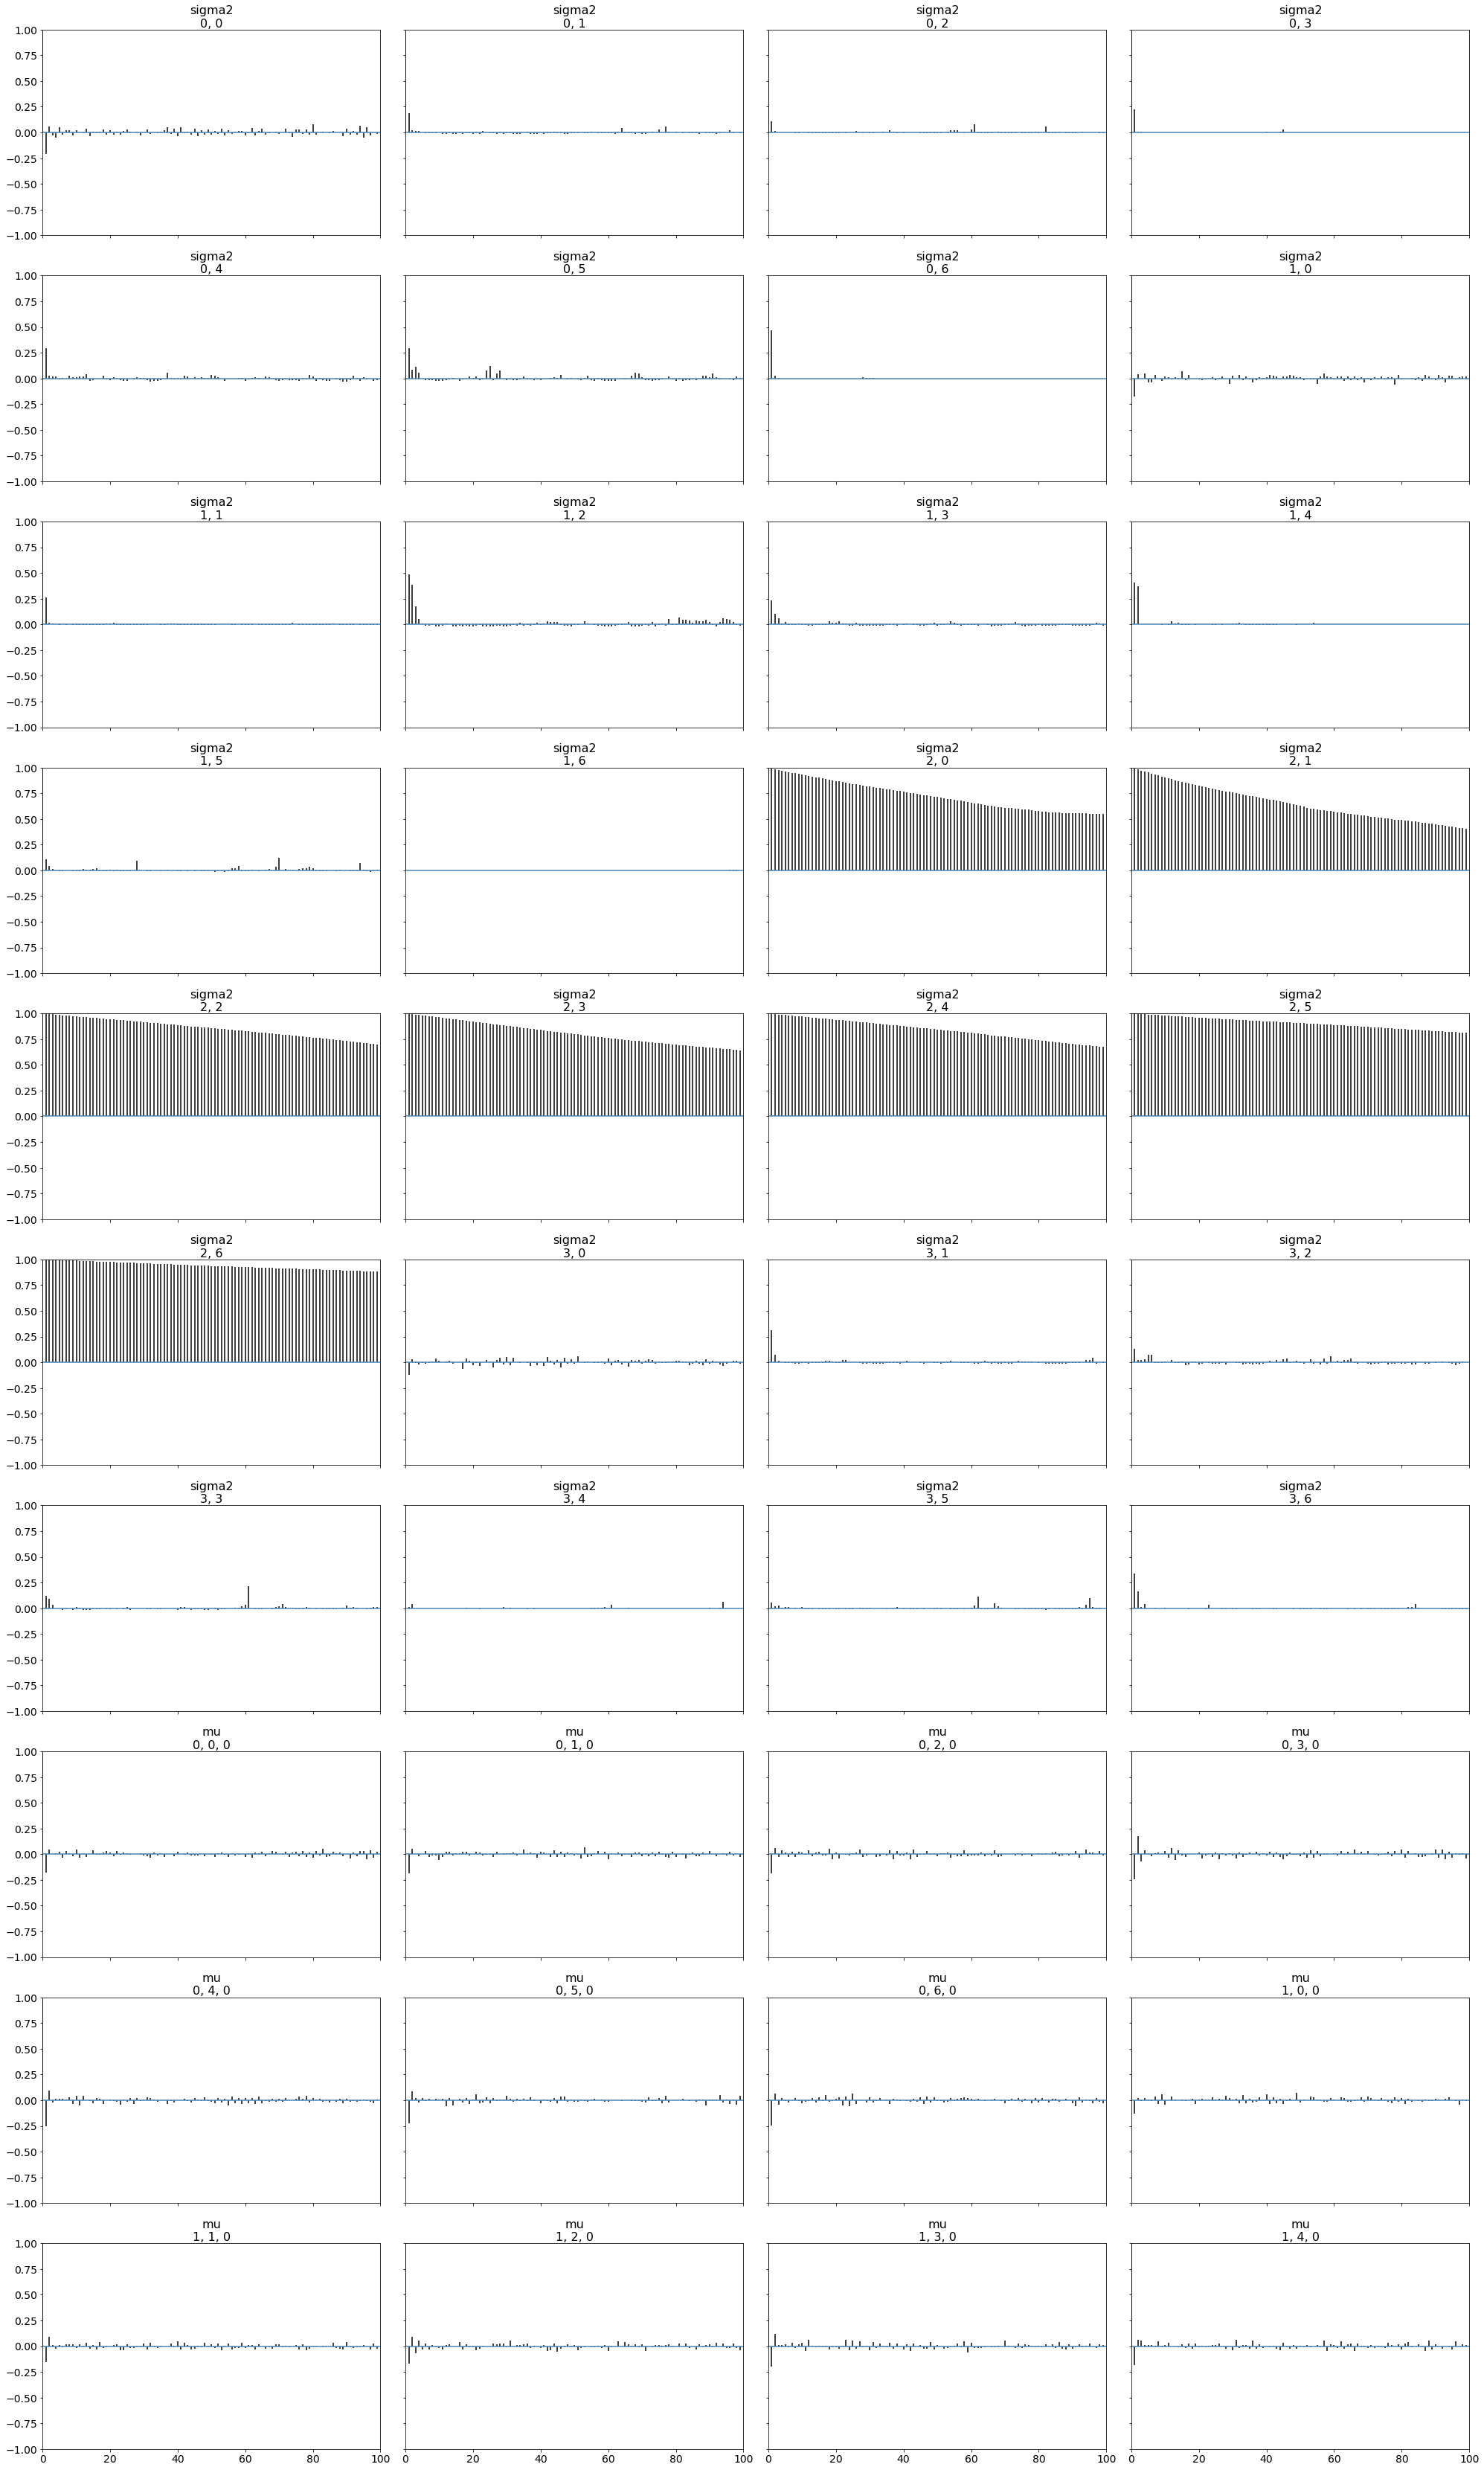

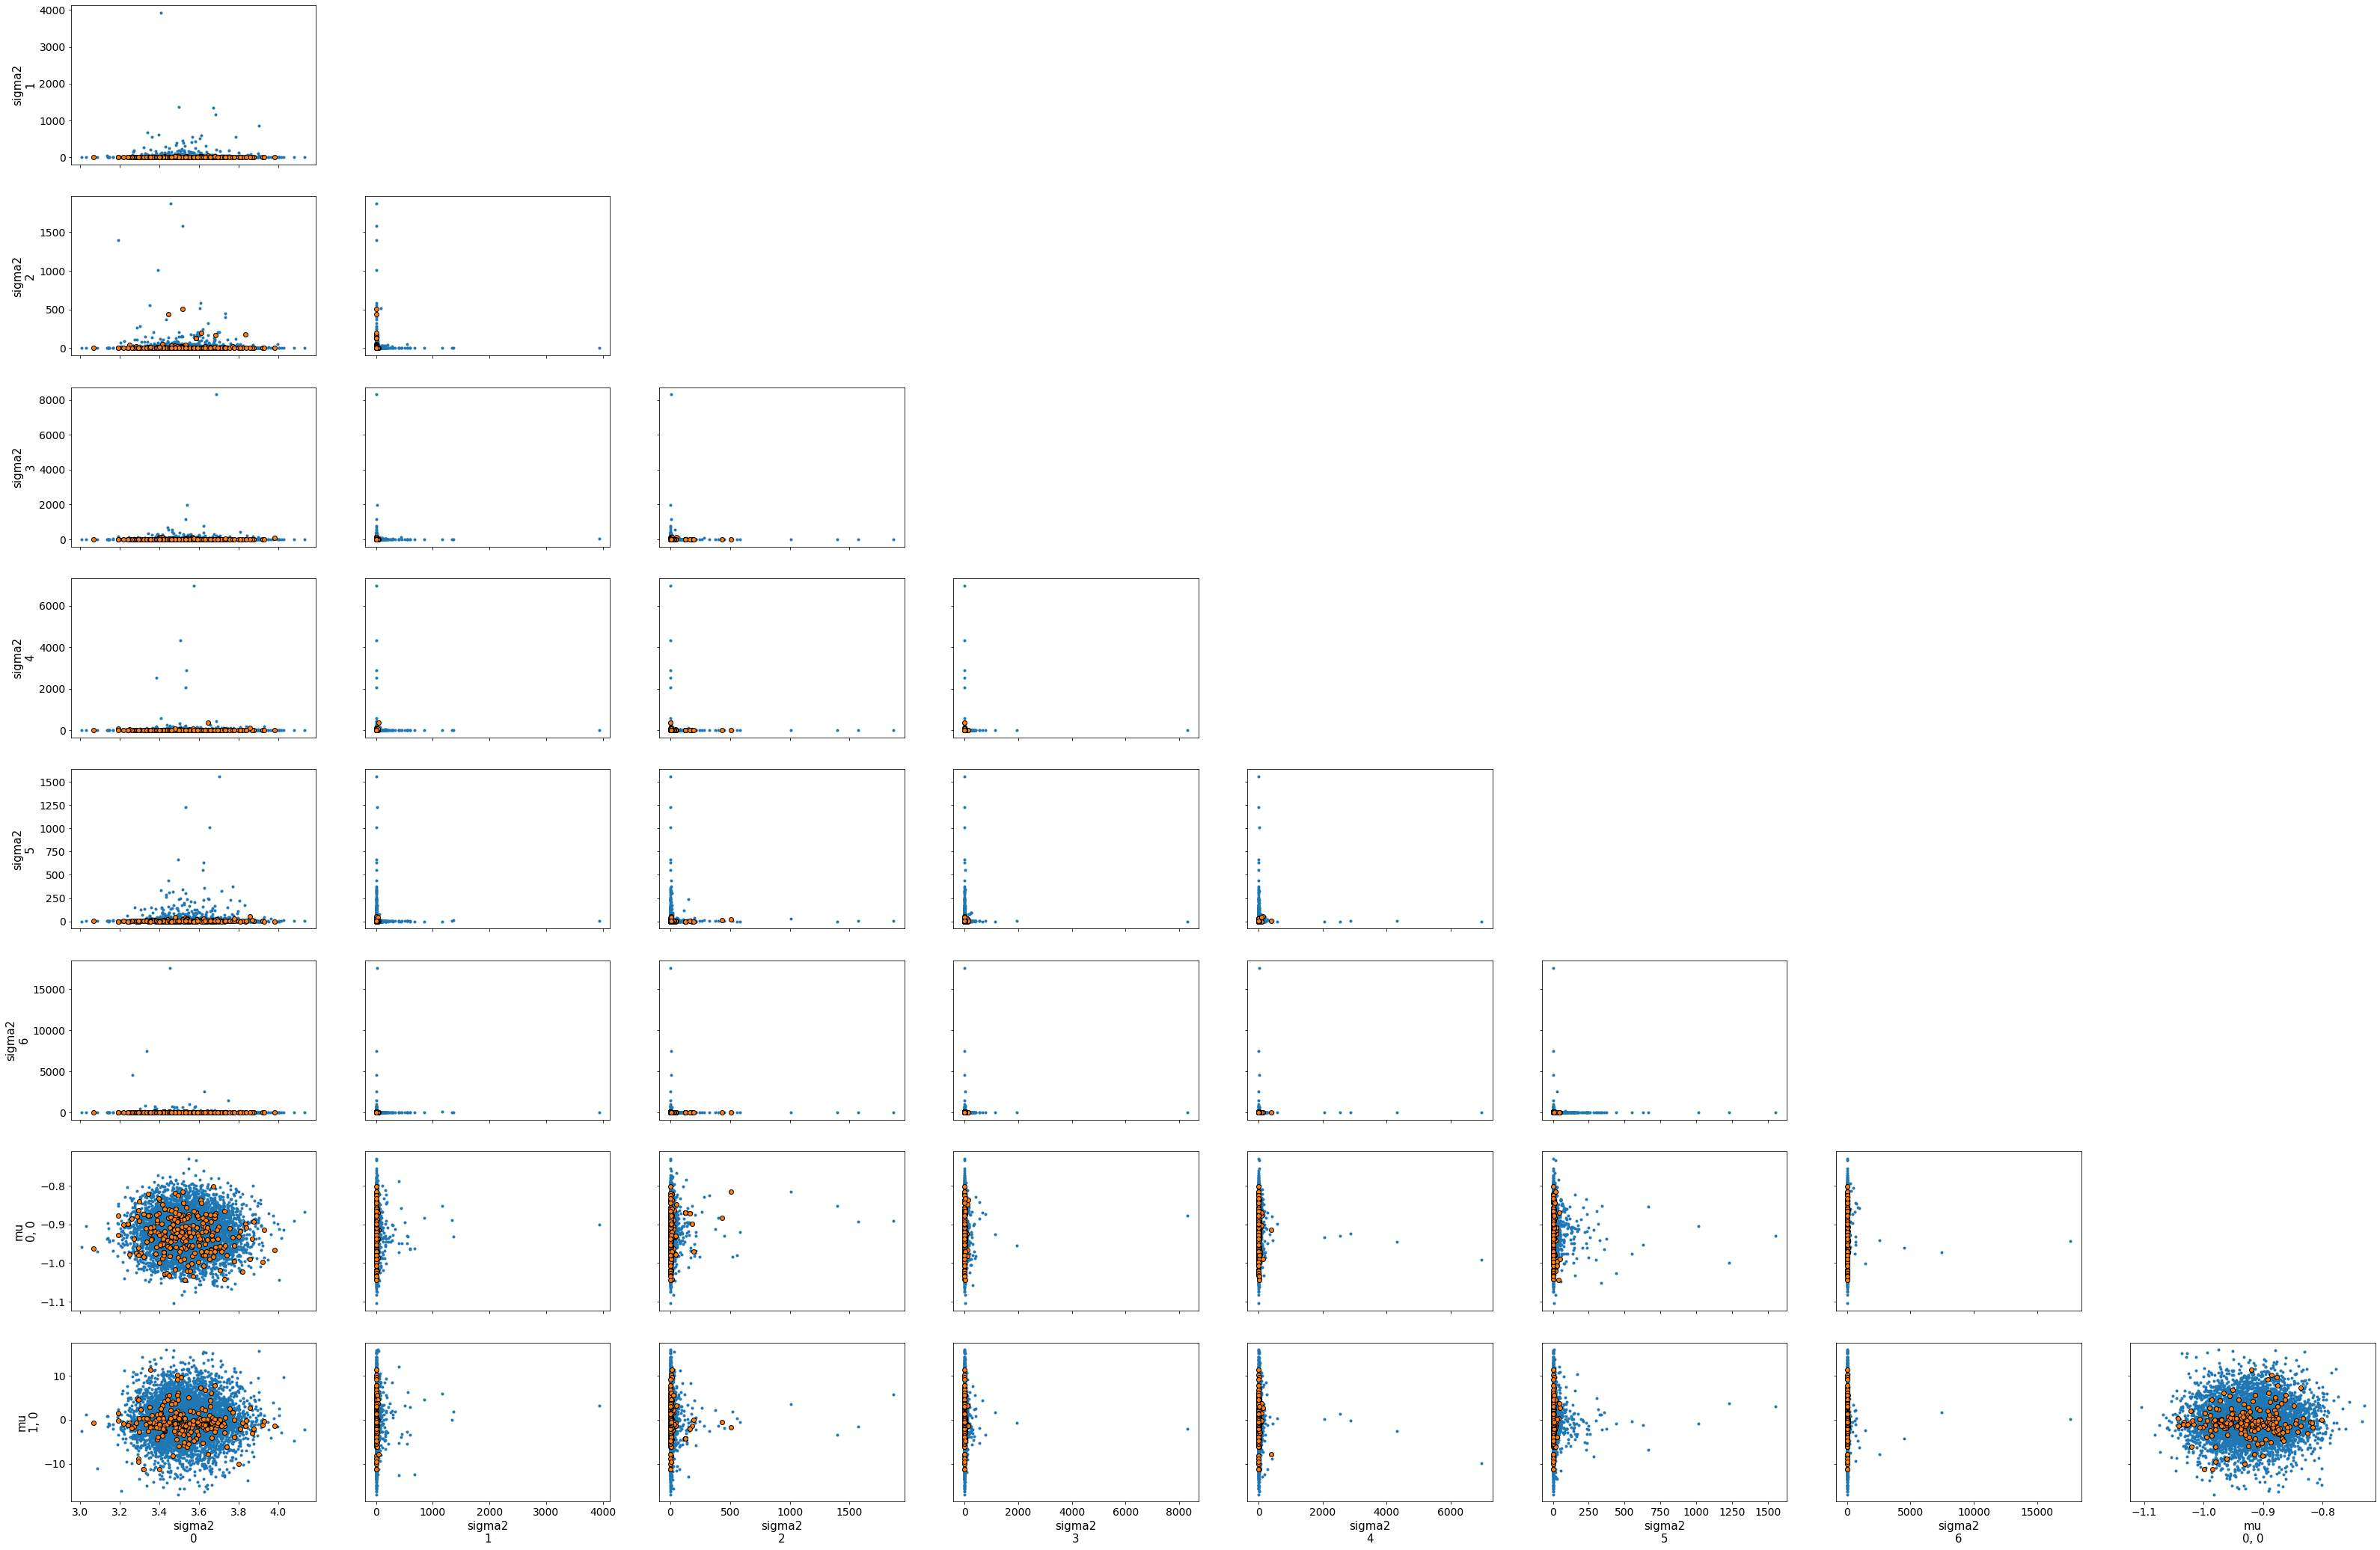

In [11]:
az_mu_sigma_plot(fitted_object['fit'])

In [12]:
fitted_object['model'].show()

StanModel object 'anon_model_98c65c1e58868b08bab6d09e08519771' coded as follows:

data {
 int D; //number of dimensions
 int K; //number of gaussians
 int N; //number of data
 vector[D] y[N]; //data
 real alpha; // components weight prior
 real power;// power posterior
}

parameters {
 real <lower=0,upper=1> v[K]; // betas
 vector[D] mu[K]; //mixture component means
 vector<lower=0>[K] sigma2; //mixture component sigma
}

transformed parameters{
  simplex[K] theta; //mixing proportions
  theta[1] = v[1];
  // stick-break process 
  for(j in 2:(K-1)){
      theta[j]= v[j]*(1-v[j-1])*theta[j-1]/v[j-1]; 
  }
  theta[K]=1-sum(theta[1:(K-1)]); // to make a simplex.
}

model {
real ps[K]; 

 for(k in 1:K){
 mu[k] ~ normal(0,5);
 sigma2[k] ~ inv_gamma(1, 1);
 v[k] ~ beta(1, alpha);   
 }
 for (n in 1:N){
 for (k in 1:K){
 ps[k] =log(theta[k])+power/(power+N)*normal_lpdf(y[n] | mu[k], sqrt(sigma2[k])); //increment log probability of the gaussian
 }
 target += log_sum_exp(ps);
 }
}



## 3.2 Trace plot with P(k=j) > threshold

Text(0.5, 1.0, 'fit_approx1995.pickle')

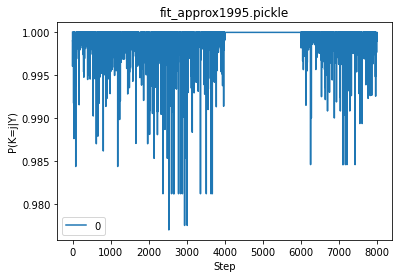

In [13]:
y_hat = plot( fitted_object ,threshold = 0.02)
plt.title(fitted_names[0] )

# 4. Predictive Posterior Check

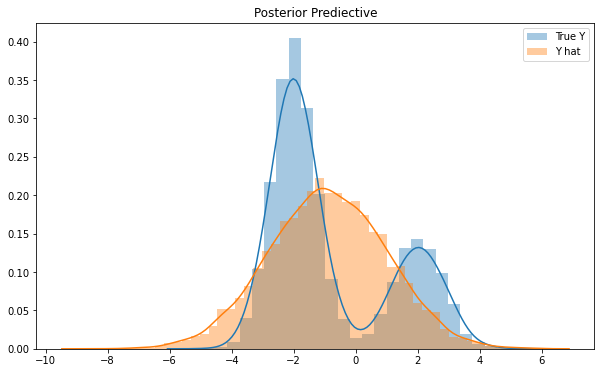

In [14]:
plt.figure(figsize=(10, 6))
sns.distplot(data['true'], label='True Y')
sns.distplot(y_hat, label ='Y hat')
plt.title('Posterior Prediective')
plt.legend()

In [ ]:
# sampling code for posterior check
pred_y = []
for j in range(np.shape(fit['fit'].to_dataframe())[0]):

    k_temp = np.random.multinomial(1, fit['fit'].extract('theta')['theta'][j, :])
    mu_temp = fit['fit'].extract('mu')['mu'][j, :]
    sigma_temp = fit['fit'].extract('sigma2')['sigma2'][j, :]

    pos_mu = np.dot(mu_temp.T, k_temp)
    pos_sigma = np.dot(sigma_temp.T, k_temp)
    pred_y.append(np.random.normal(pos_mu, np.sqrt(pos_sigma)))
